### Coeficientes de atracción mutua

Se levantan los coeficientes de atracción mutua del 1996 calculados por Macadar y Domínguez (2008), se calculan los mismos con datos del 2011 y se comparan ambas matrices

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from functions.cargar_data import *
from functions.func_demograficas import *
from functions.graficas import *

In [2]:
# setea metadatos
metadatos_figs = {'Author': '''Guillermo D'Angelo'''}

# setea tipo de fuente y tamaño
size, font, font_legend = size_font()

In [3]:
# Carga datos del Censo INE 1996
# censo 96
censo96 = cargar_censo_96()

# crea tabla de flujos
dict_rename= {'HAC5DEPC': 'depto_origen',
              'DPTO':'depto_destino',
              'LOC': 'loc_destino',
              'HAC5LOC': 'loc_origen',
              'SEXO': 'sexo',
              'EDAD': 'edad'}

censo96.rename(dict_rename, axis=1, inplace=True)

flujos_deptos96 = censo96.loc[(censo96.HACE5AQUI.isnull()) & (censo96.depto_origen <= 19)]

flujos_deptos96 = flujos_deptos96.loc[flujos_deptos96.depto_destino != flujos_deptos96.depto_origen]\
                  .reset_index(drop=True)

flujos_deptos96['personas_mig'] = 1
flujos_deptos96['depto_origen'] = flujos_deptos96['depto_origen'].astype(int)

# inserta el dato de díada codificada
flujos_deptos96.insert(0, 'cod', codif_diada_depto(flujos_deptos96))

print(flujos_deptos96.shape)
flujos_deptos96.head(2)

(193567, 15)


,cod,depto_destino,loc_destino,SECC,SEGM,VIVIENDA,TIPVIV,HOGARVIV,PARENTESCO,sexo,edad,HACE5AQUI,depto_origen,loc_origen,personas_mig
0,1301,1,20,1,1,36375,2,1,8,2,24,NaN,13,522.0,1
1,601,1,20,1,1,146352,2,1,10,1,51,NaN,6,220.0,1


In [4]:
# genera tabla pivot con los flujos de departamento a departamento
matrix = pd.crosstab(index = flujos_deptos96.depto_destino,
                     columns=flujos_deptos96.depto_origen,
                     margins=True,
                     margins_name='Total')

print(matrix)

depto_origen       1     2      3     4     5     6     7     8     9    10  \
depto_destino                                                                 
1                  0  3985  14802  3279  2597  2461   969  1958  1427  2272   
2               1277     0    159    40    56    38     7     5    18    59   
3              41077   705      0   795   330   738   183  1037   733   691   
4               1774    27    311     0    67    77    19    64    78   144   
5               2196   103    288    68     0    54   159    63    19   198   
6               1333    45    264   124    37     0   122   483    29    67   
7                569    14    117    12    91   181     0    87     8    54   
8               1477    47    679    72    75   461   119     0   248   134   
9               1373    22    491   232    25    93    17   181     0   603   
10              4891   313   1387   839   487   338   252   404  1569     0   
11              1541   262    189    52    93    79 

#### Se levanta la matriz del censo 1996 elaborada por Macadar y Domínguez, se verifica que con esa matriz de valores absolutos de obtiene la misma matriz de CAM prsentada por los autores.

In [5]:
# levanta la matriz elaborada por Macadar y Dominguez (2008)
matrix96 = pd.read_csv('tablas/matriz_deptos_96.csv', index_col='DEPID')
matrix96

# desapila la matriz
grupo_pob = matrix96.unstack().dropna().reset_index()
grupo_pob.columns = ['depto_origen', 'depto_destino', 'Mij']
grupo_pob = grupo_pob.astype(int)

# agrega Mji
Mji = list(grupo_pob.sort_values(by=['depto_destino', 'depto_origen'])['Mij'])
grupo_pob['Mji'] = Mji

# agrega Pij y Pji
pobl96 = recuperar_poblacion_1996_5años()
grupo_pob = grupo_pob.merge(pobl96, left_on='depto_origen', right_on='DPTO')
grupo_pob = grupo_pob.merge(pobl96, left_on='depto_destino', right_on='DPTO')
grupo_pob.drop(['DPTO_x', 'DPTO_y'], axis=1, inplace=True)
grupo_pob.rename({'poblacion_x': 'Pi', 'poblacion_y': 'Pj'}, inplace=True, axis=1)

grupo_pob.head()

grupo_pob['cam_round'] = get_cam(grupo_pob)

atr1996 = pd.pivot_table(grupo_pob,
                        values='cam_round',
                        index ='depto_origen',
                        columns='depto_destino',
                        fill_value=0).iloc[1:19, 0:18]

atr1996_ar = np.tril(np.array(atr1996))
print(atr1996_ar)

[[ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [34  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  0  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  1  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  1  0  2  4  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  4  1  1  9  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 2  0  2  2  0  1  0  3  0  0  0  0  0  0  0  0  0  0]
 [ 5  2  4  5  3  2  2  3 13  0  0  0  0  0  0  0  0  0]
 [ 3  3  1  0  1  1  1  1  0  3  0  0  0  0  0  0  0  0]
 [ 2  1  1  0  1  2  2  1  0  2  9  0  0  0  0  0  0  0]
 [ 5  2  2  2  1  1  0  1  0  1  2  1  0  0  0  0  0  0]
 [ 3  0  2  1  1  1  0  1  3 11  1  1  0  0  0  0  0  0]
 [ 4 11  1  0  1  0  0  0  0  3  7  1  2  0  0  0  0  0]
 [ 5  1  4  1  4  1  3  3  0  2  1  1  1  1  1  0  0  0]
 [ 3  0  1  0 10  1  3  1  0  4  2  7  0  0  1  2  0  0]
 [ 4  1  2  3  1  6  1  1  0  3  4  2  8  1  3  1  1  0]
 [ 2  0  1 13  1  2  0  2  7  7

In [6]:
# lee matriz de CAM 1996
atr1996 = pd.read_csv('tablas/atractividad_1996.csv', index_col='deptos').fillna(0)

# convierte a numpy array 
atr1996_ar_v2 = atr1996.values

comparison = atr1996_ar == atr1996_ar_v2

print('Son iguales ambos arrays?: ', comparison.all())

Son iguales ambos arrays?:  True


In [7]:
del atr1996_ar_v2

In [8]:
# recarga data
atr1996 = pd.read_csv('tablas/atractividad_1996.csv', index_col='deptos')
atr1996

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
deptos,,,,,,,,,,,,,,,,,,
2,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,34,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3,1.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3,1.0,2.0,1.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1,0.0,1.0,0.0,2.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3,0.0,4.0,1.0,1.0,9.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2,0.0,2.0,2.0,0.0,1.0,0.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,5,2.0,4.0,5.0,3.0,2.0,2.0,3.0,13.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
p_migr = cargar_migrantes_internos()
p_migr.head()

,depto_origen,depto_destino,LOC,SECC,SEGM,VIVID,TIPO_VIVIE,HOGCOD,HOGID,PERPH02,...,PERED03_1,PERED03_2,PERED04_R,PERED05_R,PERED06_R,CODIGO_CAR,PERED08,NIVELEDU_R,loc_origen,loc_destino
0,3,1,20,1,1,5,1,102001001000501,1,1,...,11,0,2,3,4,55131,1,9,3732,1020
1,17,1,20,1,1,30,1,102001001003001,1,2,...,0,0,0,2,4,55152,1,9,17220,1020
2,18,1,20,1,1,36,1,102001001003601,1,1,...,6,0,2,2,0,33101,1,5,18220,1020
3,2,1,20,1,1,46,1,102001001004601,1,1,...,6,0,2,1,0,33101,1,5,2220,1020
4,12,1,20,1,1,93,1,102001001009301,1,2,...,4,0,2,1,0,22101,1,4,12320,1020


In [10]:
# recupera población con 5 o más años de edad
pobl = recuperar_poblacion_2011_5años()
pobl.head(3)

,DPTO,poblacion
0,1,1236133
1,2,67863
2,3,484060


In [11]:
# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr.loc[p_migr.depto_origen != p_migr.depto_destino, ['depto_origen', 'depto_destino']]
grupo = flujos_deptos.groupby(by=['depto_origen', 'depto_destino']).size()
grupo = pd.DataFrame(grupo, columns=['Mij']).reset_index()

# genera un sólo dataframe solo para deptos
flujos_deptos = p_migr.loc[p_migr.depto_origen != p_migr.depto_destino, ['depto_origen', 'depto_destino']]
Mji = list(flujos_deptos.groupby(by=['depto_destino', 'depto_origen']).size())
grupo['Mji'] = Mji

grupo_pob = grupo.merge(pobl, left_on='depto_origen', right_on='DPTO')
grupo_pob = grupo_pob.merge(pobl, left_on='depto_destino', right_on='DPTO')
grupo_pob.drop(['DPTO_x', 'DPTO_y'], axis=1, inplace=True)
grupo_pob.rename({'poblacion_x': 'Pi', 'poblacion_y': 'Pj'}, inplace=True, axis=1)
grupo_pob.head()

,depto_origen,depto_destino,Mij,Mji,Pi,Pj
0,1,2,914,2395,1236133,67863
1,3,2,74,536,484060,67863
2,4,2,15,20,78717,67863
3,5,2,28,167,115155,67863
4,6,2,32,33,53162,67863


In [12]:
# calcula cam
grupo_pob['cam_round'] = get_cam(grupo_pob)

In [13]:
# genera matriz de atracción mutua
atr2011 = pd.pivot_table(grupo_pob,
                         values='cam_round',
                         index ='depto_origen',
                         columns='depto_destino',
                         fill_value=0).iloc[1:19, 0:18]

# convierte en array y reemplaza el triángulo superior por ceros
atr2011_ar = np.tril(np.array(atr2011, dtype=float))
atr2011_ar[np.triu_indices(atr2011_ar.shape[0], 1)] = np.nan
print(atr2011_ar)

[[ 3. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [26.  1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 2.  0.  1. nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 4.  1.  1.  0. nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 2.  1.  1.  1.  1. nan nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 1.  0.  0.  0.  1.  3. nan nan nan nan nan nan nan nan nan nan nan nan]
 [ 2.  0.  3.  1.  1.  6.  2. nan nan nan nan nan nan nan nan nan nan nan]
 [ 2.  0.  2.  1.  0.  1.  0.  3. nan nan nan nan nan nan nan nan nan nan]
 [ 4.  2.  3.  4.  2.  1.  1.  2.  6. nan nan nan nan nan nan nan nan nan]
 [ 2.  2.  1.  1.  1.  1.  0.  1.  0.  2. nan nan nan nan nan nan nan nan]
 [ 2.  1.  1.  0.  2.  1.  2.  1.  0.  2.  7. nan nan nan nan nan nan nan]
 [ 3.  2.  2.  2.  1.  1.  0.  1.  0.  1.  1.  1. nan nan nan nan nan nan]
 [ 2.  0.  1.  1.  0.  1.  0.  1.  2.  7.  0.  1.  0. nan nan nan nan nan]
 [ 3.  6.  1.  0.  1.  0.

In [14]:
def plot_cam(data, output_name, font=font, colors='RdBu'):
    "Plotea la grilla de CAM"
    nomdep = cargar_nombres()
    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_subplot(111)
    cax = ax.matshow(data, cmap=colors,  vmin=0, vmax=30)

    ax.grid(color='silver', linestyle='--', linewidth=0.5)

    cbar = fig.colorbar(cax, fraction=0.045, drawedges=False)

    plt.xticks(np.arange(0, 18, step=1), labels=nomdep[0:18], rotation=90, **font)
    plt.yticks(np.arange(0, 18, step=1), labels=nomdep[1:19], **font)

    ax.tick_params(axis=u'both', which=u'both',length=0)

    cbar.ax.tick_params(labelsize=size)

    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family(font['fontname'])

    cbar.ax.tick_params(size=3, color='w')

    save_chart(output_name, metadatos_figs)

    plt.show()

Se guardó la gráfica en mapas_graficas/003_eda_coef_1996.pdf


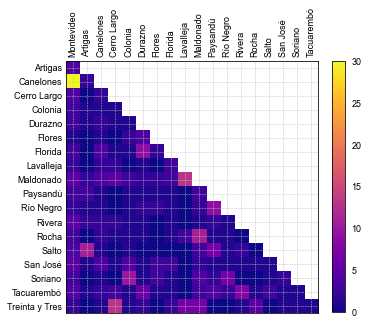

In [15]:
plot_cam(atr1996, '003_eda_coef_1996.pdf', font, colors='plasma')

Se guardó la gráfica en mapas_graficas/003_eda_coef_2011.pdf


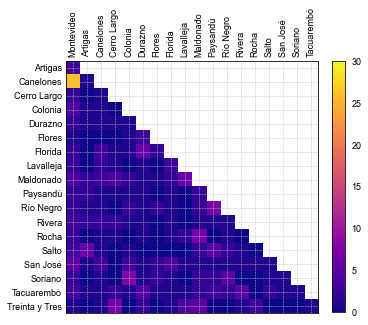

In [16]:
plot_cam(atr2011_ar, '003_eda_coef_2011.pdf', font, colors='plasma')

In [17]:
dif = atr2011_ar - atr1996_ar

# diferencias a df
cols = list(atr1996.columns)
idx  = list(atr1996.index)
dif_df = pd.DataFrame(dif, columns = cols, index=idx)
dif_df

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
2,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-8.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-2.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,1.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,-1.0,0.0,-1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,0.0,0.0,-1.0,0.0,-1.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,-1.0,0.0,-1.0,0.0,0.0,-3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,-1.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,-1.0,-1.0,0.0,1.0,0.0,0.0,-1.0,0.0,0.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Grafica diferencias de CAM entre 1996 y 2011

In [18]:
def plot_cam_diverging(data, output_name, font=font):
    "Plotea la grilla de CAM"
    nomdep = cargar_nombres()
    divnorm = colors.TwoSlopeNorm(vmin=-8, vcenter=0, vmax=1)

    # a 2D array with linearly increasing values on the diagonal
    fig = plt.figure(figsize=(5, 5))

    ax = fig.add_subplot(111)
    cax = ax.matshow(data, cmap='RdBu', norm=divnorm)

    ax.grid(color='silver', linestyle='--', linewidth=0.5)

    cbar = fig.colorbar(cax, fraction=0.045, drawedges=False)

    plt.xticks(np.arange(0, 18, step=1), labels=nomdep[0:18], rotation=90, **font)
    plt.yticks(np.arange(0, 18, step=1), labels=nomdep[1:19], **font)

    ax.tick_params(axis=u'both', which=u'both',length=0)

    cbar.ax.tick_params(labelsize=size)

    for l in cbar.ax.yaxis.get_ticklabels():
        l.set_family(font['fontname'])

    cbar.ax.tick_params(size=3, color='w')

    save_chart(output_name, metadatos_figs)

    plt.show()

Se guardó la gráfica en mapas_graficas/003_eda_delta_coef_1996_2011.pdf


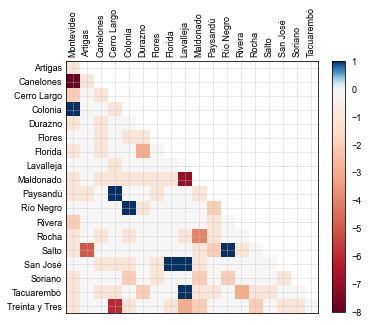

In [19]:
plot_cam_diverging(dif, '003_eda_delta_coef_1996_2011.pdf', font)

In [20]:
print('Menor atractivididad: {}. Estables: {}. Mayor atractividad {}'\
      .format(len(dif[dif<0]), len(dif[dif==0]), len(dif[dif>0])))

Menor atractivididad: 71. Estables: 93. Mayor atractividad 7


#### Exporta tablas a latex

In [21]:
# decodifica índice
atr1996.set_index(decode_depto_short(atr1996.index), inplace=True)

# renombra índice
atr1996.index.names = ['depto origen']

In [22]:
# setea ancho de columnas
ancho = 'p{0.25cm}'
colformato='l' + ancho * 20

# exporta 1996
atr1996.to_latex(buf="tablas/matriz_atr1996.tex",
bold_rows=False,
na_rep='',
float_format="{:0.0f}".format,
column_format = colformato,
caption= 'Matriz de coeficientes de atracción mutua interdepartamental 1996 (Macadar y Domínguez, 2005)')

In [23]:
# exporta 2011

# convierte el erray de 2011 en DF
cols = list(atr2011.columns)
idx  = decode_depto_short((atr2011.index))
atr2011_ar_df = pd.DataFrame(atr2011_ar, columns = cols, index=idx)

# exporta el DF a latex
atr2011_ar_df.to_latex(buf="tablas/matriz_atr2011.tex",
bold_rows=False,
na_rep='',
float_format="{:0.0f}".format,
column_format = colformato,
caption= 'Matriz de coeficientes de atracción mutua interdepartamental 2011, elaboración propia en base a INE (2011)')